#Load Dataset

In [1]:
import torch
import pandas as pd
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm

In [5]:
pip install transformers

In [6]:
from google.colab import drive
drive.mount('//content//drive')

Mounted at //content//drive


In [9]:
pp_ds=pd.read_csv("/content/drive/MyDrive/DS_CSE 438/Dataset/UrduDataset/Urdu_sampled_dataset.csv")

In [10]:
pp_ds

,Text,Category,label
0,ٹوئٹر سو سے زیادہ نواز شریف ظاہر مریم بھی پریش...,Joy,0
1,مہر صاحب ایں اپنا غداری ریا,Joy,0
2,تم بھی میری بھی میری,Joy,0
3,چا ہنے والوں بتا ؤ عزتیں اللہ دیتا,Joy,0
4,روٹی دا انتظام ہیگا,Joy,0
...,...,...,...
13075,پتہ نہیں ایسے نہیں رہا جیسے نکے نکے ابے کا گین...,Surprice,5
13076,اتنی بار ھاھاھاھاھا میں گن بھی نہیں پاٸی,Surprice,5
13077,کیا ہوگیا عبیرہ,Surprice,5
13078,اپنی حرکتوں سے باز نہیں رہا گندے سور نا جائز ا...,Surprice,5


# Create a 85-15 train-test split.



In [11]:
import numpy as np
df_train, df_test = np.split(pp_ds.sample(frac=1, random_state=4040), [int(.85*len(pp_ds))])
print('{:>5,} training samples'.format(len(df_train)))
print('{:>5,} test samples'.format(len(df_test)))

11,118 training samples
1,962 test samples


In [12]:
df_train['label'] = df_train['label'].replace(['SAD', 'HATE', 'OTHER', 'FEAR', 'ANGRY', 'HAPPY', 'SURPRISE'], [0, 1, 2, 3, 4, 5, 6])
df_train = df_train.reset_index(drop=True)
comments_a = df_train['Text'].tolist()
labels = df_train['label'].tolist()
num_labels = len(df_train['label'].unique())
print(df_train.shape)
pp_ds

(11118, 3)


,Text,Category,label
0,ٹوئٹر سو سے زیادہ نواز شریف ظاہر مریم بھی پریش...,Joy,0
1,مہر صاحب ایں اپنا غداری ریا,Joy,0
2,تم بھی میری بھی میری,Joy,0
3,چا ہنے والوں بتا ؤ عزتیں اللہ دیتا,Joy,0
4,روٹی دا انتظام ہیگا,Joy,0
...,...,...,...
13075,پتہ نہیں ایسے نہیں رہا جیسے نکے نکے ابے کا گین...,Surprice,5
13076,اتنی بار ھاھاھاھاھا میں گن بھی نہیں پاٸی,Surprice,5
13077,کیا ہوگیا عبیرہ,Surprice,5
13078,اپنی حرکتوں سے باز نہیں رہا گندے سور نا جائز ا...,Surprice,5


#Using Colab GPU for Training

In [15]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

SystemError: ignored

#Preparing train data

In [ ]:
from transformers import AutoTokenizer

# Using Multilingual BERT Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")


##Encoding the data

In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
for comment_a in comments_a:

    encoded_dict = tokenizer.encode_plus(
        comment_a,                   # Sentence to encode.
        truncation=True,
        add_special_tokens=True,     # Add '[CLS]' and '[SEP]'
        max_length=270,              # Pad & truncate all sentences.
        padding='max_length',
        return_attention_mask=True,  # Construct attention masks.
        return_tensors='pt',         # Return PyTorch tensors.
        return_token_type_ids=True,
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    token_type_ids.append(encoded_dict['token_type_ids'])
input_ids = torch.cat(input_ids, dim=0)
token_type_ids = torch.cat(token_type_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('comment_a: ', comments_a[0])
print('Token IDs:', input_ids[0])
print('Token Type IDs:', token_type_ids[0])
print('Token Attention Mask:', attention_masks[0])

comment_a:  تجھ مرچی میں کیا کروں
Token IDs: tensor([  101,   766, 13027, 25908,   788, 10673, 37547, 10916, 17651, 15896,
        13378,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     

#Import the Multilingual BERT model

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoConfig, AdamW

num_classes = 7
# Using Multilingual BERT model
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=num_classes,
    output_attentions=False,
    output_hidden_states=False,
    hidden_dropout_prob=0.1,
)
config = AutoConfig.from_pretrained("bert-base-multilingual-cased")
if device.type == 'cuda':
  model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: ignored

##Combine the training inputs into a TensorDataset

In [ ]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
print('{:>5,} training samples'.format(len(train_dataset)))

In [ ]:
labels

##Create dataloaders

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

##Create Optimizer, Scheduler, Accuracy, Elapsed time

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

##Training loop

In [ ]:
import random
import numpy as np
seed_val = 2020

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []
total_t0 = time.time()
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_token_type_ids =  batch[1].to(device)
        b_input_mask = batch[2].to(device)
        b_labels = batch[3].to(device)
        model.zero_grad()
        outputs = model(b_input_ids,
                        token_type_ids=b_token_type_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss, logits = outputs.loss, outputs.logits
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

# Preparing test data

In [ ]:
df_test['label'] = df_test['label'].replace(['SAD', 'HATE', 'OTHER', 'FEAR', 'ANGRY', 'HAPPY', 'SURPRISE'], [0, 1, 2, 3, 4, 5, 6])
df_test = df_test.reset_index(drop=True)

comments_a = df_test['tweets'].tolist()
labels = df_test['label'].tolist()
num_labels = len(df_test['label'].unique())

print(df_test.shape)
df_test.head(5)

In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
for comment_a in comments_a:
    encoded_dict = tokenizer.encode_plus(
        comment_a,                   # Sentence to encode.
        truncation=True,
        add_special_tokens=True,     # Add '[CLS]' and '[SEP]'
        max_length=270,              # Pad & truncate all sentences.
        padding='max_length',
        return_attention_mask=True,  # Construct attention masks.
        return_tensors='pt',         # Return PyTorch tensors.
        return_token_type_ids=True,
    )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    token_type_ids.append(encoded_dict['token_type_ids'])
input_ids = torch.cat(input_ids, dim=0)
token_type_ids = torch.cat(token_type_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
print('comment_a: ', comments_a[0])
print('Token IDs:', input_ids[0])
print('Token Type IDs:', token_type_ids[0])
print('Token Attention Mask:', attention_masks[0])

In [ ]:
test_dataset = TensorDataset(input_ids, token_type_ids, attention_masks, labels)
print('{:>5,} test samples'.format(len(test_dataset)))
batch_size = 32
prediction_data = test_dataset
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

#Model Evaluation on Test Data

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_data)))
model.eval()
predictions , true_labels = [], []
total_eval_accuracy=0

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_token_type, b_input_mask, b_labels = batch
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids= b_token_type,
                      attention_mask=b_input_mask)
  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  predictions.append(logits)
  true_labels.append(label_ids)
  total_eval_accuracy += flat_accuracy(logits, label_ids)
avg_val_accuracy = total_eval_accuracy / len(prediction_dataloader)
print("  Accuracy: {0:.3f}".format(avg_val_accuracy))

In [ ]:
from sklearn import metrics
preds = [j for i in predictions for j in i]
preds_flat = np.argmax(preds, axis=1).flatten()
labels = [j for i in true_labels for j in i]
f1_score_micro = metrics.f1_score(labels, preds_flat, average='macro')
print("  f1_score: {0:.3f}".format(f1_score_micro))

In [ ]:
from sklearn.metrics import precision_score, recall_score
preds = [j for i in predictions for j in i]
preds_flat = np.argmax(preds, axis=1).flatten()
labels = [j for i in true_labels for j in i]
precision = precision_score(labels, preds_flat, average='macro')
recall = recall_score(labels, preds_flat, average='macro')
print("  Precision: {0:.3f}".format(precision))
print("  Recall: {0:.3f}".format(recall))


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
preds = [j for i in predictions for j in i]
preds_flat = np.argmax(preds, axis=1).flatten()
labels = [j for i in true_labels for j in i]
conf_matrix = confusion_matrix(labels, preds_flat)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
class_labels = ['SAD', 'HATE', 'OTHER', 'FEAR', 'ANGRY', 'HAPPY', 'SURPRISE']

preds = [j for i in predictions for j in i]
preds_flat = np.argmax(preds, axis=1).flatten()
labels = [j for i in true_labels for j in i]


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


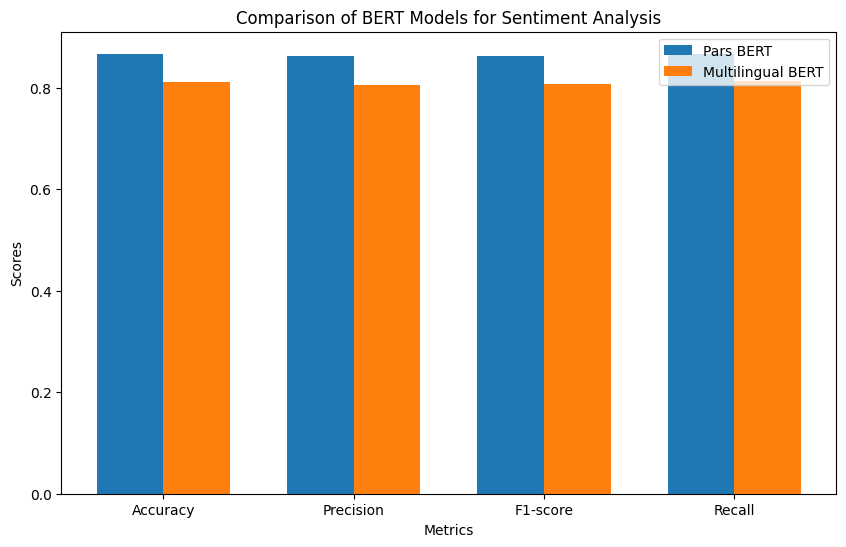

In [ ]:
import matplotlib.pyplot as plt
model1_metrics = {'Accuracy': 0.866, 'Precision': 0.863, 'F1-score': 0.863, 'Recall': 0.867}
model2_metrics = {'Accuracy': 0.812, 'Precision': 0.806, 'F1-score': 0.807, 'Recall': 0.813}
metrics = list(model1_metrics.keys())
model1_values = list(model1_metrics.values())
model2_values = list(model2_metrics.values())
bar_width = 0.35
index = range(len(metrics))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index, model1_values, bar_width, label='Pars BERT')
bar2 = ax.bar([i + bar_width for i in index], model2_values, bar_width, label='Multilingual BERT')
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of BERT Models for Sentiment Analysis')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(metrics)
ax.legend()
plt.show()

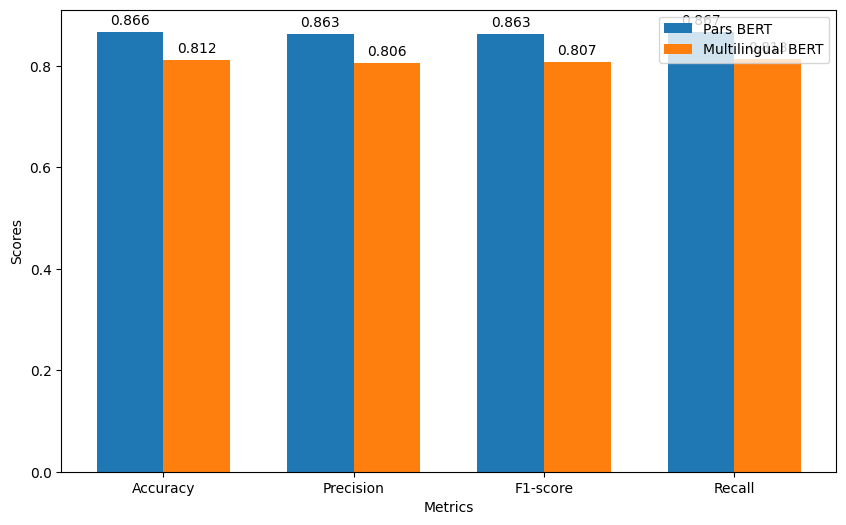

In [ ]:
import matplotlib.pyplot as plt
model1_metrics = {'Accuracy': 0.866, 'Precision': 0.863, 'F1-score': 0.863, 'Recall': 0.867}
model2_metrics = {'Accuracy': 0.812, 'Precision': 0.806, 'F1-score': 0.807, 'Recall': 0.813}
metrics = list(model1_metrics.keys())
model1_values = list(model1_metrics.values())
model2_values = list(model2_metrics.values())
bar_width = 0.35
index = range(len(metrics))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index, model1_values, bar_width, label='Pars BERT')
bar2 = ax.bar([i + bar_width for i in index], model2_values, bar_width, label='Multilingual BERT')
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(metrics)
ax.legend()
def add_values_on_top(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values_on_top(bar1)
add_values_on_top(bar2)
plt.show()
